In [6]:
import os
import requests
import re
import ast
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import names, stopwords, words
from nltk.tokenize import word_tokenize
from rake_nltk import Rake
import nltk
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

### Get Data

In [9]:
def get_news(q, df=True, from_date=None, to_date=None, language=None, searchIn=None, page_size=None, page=None):
    endpoint = 'https://newsapi.org/v2/everything'
    params = {
        'apiKey': os.getenv('NEWS_API_KEY'),
        'pageSize': page_size,
        'page': page
    }

    query_params = {
        'q': q,
        'from': from_date,
        'to': to_date,
        'language': language,
        'searchIn': searchIn
    }

    for key, value in query_params.items():
        if value is not None:
            params[key] = value

    response = requests.get(endpoint, params=params)
    response.raise_for_status()
    print(response.url)

    if df:
        return pd.json_normalize(pd.DataFrame(response.json())['articles'])
    else:
        return response.json()

In [11]:
df = get_news(
    q=f"{'water+climate+change+river+drinking'}", 
    df=True, 
    from_date='2024-09-08', 
    to_date='2024-10-08', 
    language='en',
    page_size=100, 
    page=1
)

display(df)

https://newsapi.org/v2/everything?apiKey=935933a6b0ce488f86af5022580c4f62&pageSize=100&page=1&q=water%2Bclimate%2Bchange%2Briver%2Bdrinking&from=2024-09-08&to=2024-10-08&language=en


,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Lauren Sommer,Hurricanes are dangerous far from the coast. C...,Coastal cities often bear the brunt of hurrica...,https://www.npr.org/2024/10/01/nx-s1-5133530/h...,https://npr.brightspotcdn.com/dims3/default/st...,2024-10-02T09:00:00Z,Hurricane Helenes destructive path tore across...,None,NPR
1,None,New tool to help decision-makers navigate poss...,The Colorado River is a vital source of water ...,https://www.sciencedaily.com/releases/2024/09/...,https://www.sciencedaily.com/images/scidaily-i...,2024-09-20T20:08:11Z,The Colorado River is a vital source of water ...,None,Science Daily
2,Matthew Carroll,New tool to help decision makers navigate poss...,The Colorado River is a vital source of water ...,https://phys.org/news/2024-09-tool-decision-ma...,https://scx2.b-cdn.net/gfx/news/hires/2024/new...,2024-09-21T15:05:35Z,The Colorado River is a vital source of water ...,None,Phys.Org
3,"Ariel Wittenberg, E&E News","Hurricanes Helene’s Floods Swamped a Hospital,...",Hurricane Helene forced dozens of medical faci...,https://subscriber.politicopro.com/article/een...,https://static.scientificamerican.com/dam/m/78...,2024-10-02T18:45:00Z,CLIMATEWIRE | A dramatic helicopter evacuation...,None,Politicopro.com
4,Al Jazeera,Water levels in major Amazon tributary tumble ...,Climate change and below-average rainfall have...,https://www.aljazeera.com/gallery/2024/10/5/wa...,https://www.aljazeera.com/wp-content/uploads/2...,2024-10-05T01:49:16Z,Its one of the largest rivers in the world. An...,al-jazeera-english,Al Jazeera English
...,...,...,...,...,...,...,...,...,...
91,Dariel Pradas,A Cuban Town Improves Water Quality Through De...,"Overnight, hundreds of people in the rural com...",https://www.ipsnews.net/2024/09/cuban-town-imp...,https://www.ipsnews.net/Library/2024/09/Agua-1...,2024-09-09T15:44:14Z,"Editors' Choice, Featured, Headlines, Health, ...",None,Inter Press Service
92,Khabarhub,Langtang National Park: Understanding climate ...,Langtang National Park — Nepal’s High Mountain...,https://english.khabarhub.com/2024/18/397905/,https://english.khabarhub.com/wp-content/uploa...,2024-09-18T06:15:48Z,Langtang National Park — Nepal’s High Mountain...,None,Khabarhub.com
93,Oritro Karim,Typhoon Yagi Devastates Southeast Asia,"In early September, Typhoon Yagi, a deadly tro...",https://www.ipsnews.net/2024/09/typhoon-yagi-d...,https://www.ipsnews.net/Library/2024/09/The-af...,2024-09-19T09:57:08Z,"Asia-Pacific, Climate Change, Economy &amp; Tr...",None,Inter Press Service
94,Dima Al-Khatib,A Better Tomorrow with South-South Cooperation,The annual United Nations Day for South-South ...,https://www.ipsnews.net/2024/09/better-tomorro...,https://www.ipsnews.net/Library/2024/09/A-Bett...,2024-09-12T06:17:13Z,"Civil Society, Development &amp; Aid, Economy ...",None,Inter Press Service


In [12]:
# Function to parse the content of each article
def parse_article_content(url):
    print(url)
    try:
        response = requests.get(url, timeout=10)  # Set a timeout of 10 seconds
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(e)
        return None
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract the text from the article
    paragraphs = soup.find_all('p')
    article_text = ' '.join([para.get_text() for para in paragraphs])
    words = re.findall(r'\b\w+\b', article_text)
    return words

# Apply the function to each URL in the dataframe
df['parsed_content'] = df['url'].apply(parse_article_content)

https://www.npr.org/2024/10/01/nx-s1-5133530/hurricane-helene-rain-flooding-climate-change
https://www.sciencedaily.com/releases/2024/09/240920160811.htm
403 Client Error: Forbidden for url: https://www.sciencedaily.com/releases/2024/09/240920160811.htm
https://phys.org/news/2024-09-tool-decision-makers-futures-colorado.html
400 Client Error: Bad request for url: https://phys.org/news/2024-09-tool-decision-makers-futures-colorado.html
https://subscriber.politicopro.com/article/eenews/2024/10/02/a-dangerous-rescue-helene-made-a-hospital-almost-inescapable-00181734
https://www.aljazeera.com/gallery/2024/10/5/water-levels-in-major-amazon-tributary-tumble-to-record-lows-amid-drought
https://phys.org/news/2024-09-amazon-river-dries-hellish-villagers.html
400 Client Error: Bad request for url: https://phys.org/news/2024-09-amazon-river-dries-hellish-villagers.html
https://www.aljazeera.com/news/2024/9/19/storm-boris-floods-northern-italy-as-leaders-to-discuss-eu-aid-in-poland
https://phys.or

In [6]:
df = df.dropna(subset=['parsed_content'])
df = df.drop_duplicates(subset=['title'])
display(df['parsed_content'])
# Save raw data
df.to_csv('data/water+climate+change+river+drinking_news_202140908_20241008.csv', index=False)

NameError: name 'df' is not defined

### Clean Data

In [7]:
# Download the list of English words and stopwords
nltk.download('words')
nltk.download('stopwords')
english_words = set(nltk.corpus.words.words())
stop_words = set(stopwords.words('english'))

# Load the data
df = pd.read_csv('data/water+climate+change+river+drinking_news_202140908_20241008.csv')

def clean_content(content):
    if isinstance(content, list):
        content = ' '.join(content)
    
    # Convert to lowercase
    content = content.lower()
    
    # Replace 'climate change' with 'climatechange'
    content = content.replace('climate change', 'climatechange')
    
    # Remove numbers and dates
    content = re.sub(r'\d+', '', content)
    content = re.sub(r'\b\d{4}\b', '', content)  # Remove 4-digit years
    
    # Summarize the content
    parser = PlaintextParser.from_string(content, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, 5)  # Summarize to 5 sentences
    content = ' '.join([str(sentence) for sentence in summary])
    
    # Initialize RAKE
    rake = Rake()
    
    # Extract keywords
    rake.extract_keywords_from_text(content)
    keywords = rake.get_ranked_phrases()
    
    # Filter out non-English words and stopwords
    keywords = [word for word in keywords if word in english_words and word not in stop_words]
    
    # Remove duplicate words within a transaction
    keywords = list(set(keywords))
    
    return keywords

# Apply the clean_content function
df['transactions'] = df['parsed_content'].apply(ast.literal_eval)
df['cleaned_content'] = df['transactions'].apply(clean_content)

# Remove duplicates
df = df.drop_duplicates(subset=['cleaned_content'])

# Remove rows with empty cleaned_content
df = df[df['cleaned_content'].apply(lambda x: len(x) > 0)]

# Display the DataFrame
display(df[['parsed_content', 'transactions', 'cleaned_content']])

# Convert series of lists into a format suitable for R's read.transactions
def write_basket_format(df, filename):
    with open(filename, 'w') as f:
        for transaction in df['cleaned_content']:
            f.write(','.join(transaction) + '\n')

# Write to a text file
write_basket_format(df, 'transactions_basket.txt')

[nltk_data] Downloading package words to
[nltk_data]     /Users/garrettflowers/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garrettflowers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,parsed_content,transactions,cleaned_content
0,"['Lauren', 'Sommer', 'Extreme', 'rain', 'is', ...","[Lauren, Sommer, Extreme, rain, is, becoming, ...","[known, works, warning, know, rainfall, floodi..."
2,"['In', 'Pictures', 'It', 's', 'one', 'of', 'th...","[In, Pictures, It, s, one, of, the, largest, r...","[community, also, world, intense, end, country..."
3,"['Italy', 's', 'Emilia', 'Romagna', 'region', ...","[Italy, s, Emilia, Romagna, region, sees, thre...","[aid, suspended, led, frequency, evacuation, c..."
4,"['Yves', 'here', 'Yours', 'truly', 'has', 'bee...","[Yves, here, Yours, truly, has, been, under, r...","[pacific, glass, amount, return, prepared, cha..."
5,"['GAMBOA', 'PANAMA', 'SEPTEMBER', '20', 'In', ...","[GAMBOA, PANAMA, SEPTEMBER, 20, In, an, aerial...","[causing, post, background, resulting, open, a..."
6,"['Increasingly', 'severe', 'water', 'shortages...","[Increasingly, severe, water, shortages, repre...","[also, already, resolved, link, receive, syste..."
7,"['Water', 'levels', 'in', 'many', 'of', 'the',...","[Water, levels, in, many, of, the, rivers, in,...","[anchored, agriculture, role, critical, likely..."
8,"['Δ', 'A', 'nonprofit', 'independent', 'media'...","[Δ, A, nonprofit, independent, media, organiza...","[spread, addition, uranium, interview, return,..."
9,"['Read', 'The', 'Diplomat', 'Know', 'The', 'As...","[Read, The, Diplomat, Know, The, Asia, Pacific...","[damage, goods, response, flooding, shelter, s..."
10,"['Plus', 'Adam', 'Neumann', 's', 'climate', 'c...","[Plus, Adam, Neumann, s, climate, company, is,...","[post, open, end, go, work, event, purpose, ma..."


In [8]:
# Display transaction top 5 lines
with open('transactions_basket.txt', 'r') as f:
    for i, line in enumerate(f):
        if i < 5:
            print(line.strip())
        else:
            break

known,works,warning,know,rainfall,flooding,country,rest,reflect,hard,ground,soaking,turn,becoming,happening,cut,city,make,river,runoff,rebuild,live,difference,u,mud,professor,adequate,sign,risk,cutting,isolated,effort,eliminate,able,infrastructure,fast,think,designed,year,deadly,severity,atlas,trend,imagine,problem,situation,making,today,set,streets,hurricane,may,built,rain,hold,depend,category,disaster,chance,better,future,plan,longer,association,people,safety,much,continue,going,safe,handle
community,also,world,intense,end,country,right,spark,people,researcher,percent,one,measurement,paper,bathing,around,shrunk,tumble,statement,brazil,fallen,covered,told,transportation,port,water,jump,head,environmental,stress,weekend,north,drought,suffering,common,way,effects,everything,depth,struggling,much,revenue
aid,suspended,led,frequency,evacuation,country,contribution,electricity,person,disposed,upriver,city,place,intensity,money,met,mayor,mud,wave,increasing,fallen,said,infrastructure,five,h

### ARM

Warning message:
"package 'arules' was built under R version 4.3.3"
Loading required package: Matrix


Attaching package: 'arules'


The following objects are masked from 'package:base':

    abbreviate, write




Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
         NA    0.1    1 none FALSE            TRUE       5     0.2      1
 maxlen            target  ext
     10 frequent itemsets TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 11 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[3627 item(s), 56 transaction(s)] done [0.00s].
sorting and recoding items ... [67 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
sorting transactions ... done [0.00s].
writing ... [292 set(s)] done [0.00s].
creating S4 object  ... done [0.00s].
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.2      1
 maxlen target  ext
     10  rules TRUE

Algo

Warning message:
"Unknown control parameters: type"


Available control parameters (with default values):
layout	 =  stress
circular	 =  FALSE
ggraphdots	 =  NULL
edges	 =  <environment>
nodes	 =  <environment>
nodetext	 =  <environment>
colors	 =  c("#EE0000FF", "#EEEEEEFF")
engine	 =  ggplot2
max	 =  100
verbose	 =  FALSE


Warning message:
"Too many rules supplied. Only plotting the best 100 using 'lift' (change control parameter max if needed)."


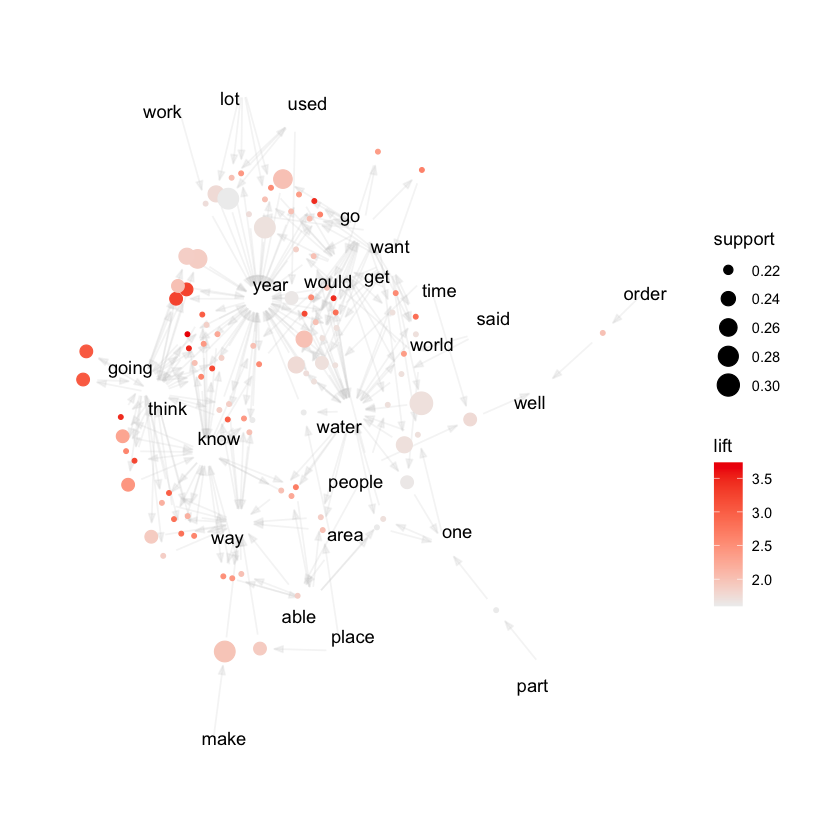

In [1]:
# Load necessary libraries
library(arules)
library(arulesViz)

# Read transactions
data <- read.transactions("transactions_basket.txt", format = "basket", sep = ",")

# Generate frequent itemsets
frequent_itemsets <- apriori(data, parameter = list(supp = 0.2, target = "frequent itemsets"))

# Generate association rules
rules <- apriori(data, parameter = list(supp = 0.2, conf = 0.8, target = "rules"))

# Check if any rules were generated
if (length(rules) > 0) {
  # Print top 15 rules by support
  top_support <- sort(rules, by = "support", decreasing = TRUE)[1:15]
  cat("Top 15 rules by support:\n")
  inspect(top_support)
  
  # Print top 15 rules by confidence
  top_confidence <- sort(rules, by = "confidence", decreasing = TRUE)[1:15]
  cat("\nTop 15 rules by confidence:\n")
  inspect(top_confidence)
  
  # Print top 15 rules by lift
  top_lift <- sort(rules, by = "lift", decreasing = TRUE)[1:15]
  cat("\nTop 15 rules by lift:\n")
  inspect(top_lift)
  
  # Plot the rules
  plot(rules, method = "graph", control = list(type = "items"))
} else {
  print("No association rules were generated.")
}